<a href="https://colab.research.google.com/github/provision95/DAP_project/blob/main/DAproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing ETH price and webscrapping Reddit to find useful insights.
This project is focused on understanding the basic concepts of web scrapping, data obtaining and cleansing, visualization and ML. The main goal is to test the correlation between crypto asset price and redditers' opinions.

---
Plan:
*   Aquire ETH data from coinbase.
*   Aquire useful information from Reddit/r/ethtrader and other sources.
*   Preprocess the data.
*   Visualize the data.
*   Train a prediction model.
---






In [174]:
!pip install praw flair #praw - reddit api wrapper fro python, flair - sentiment analyzer

In [175]:
import numpy as np
import pandas as pd
import praw
import requests
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Getting the ETH/USD data from Coinbase.
The script is written using different referencing sources: TDS/StackOverflow/Coinbase API.

In [176]:
def fetch_daily_cryptoData(symbol):
  pair_split = symbol.split('/')  # symbol to get
  symbol = pair_split[0] + '-' + pair_split[1]
  url = f'https://api.pro.coinbase.com/products/{symbol}/candles?granularity=86400'
  response = requests.get(url)

  if response.status_code == 200:  # got the data
    cryptoData = pd.DataFrame(json.loads(response.text), columns=['date', 'low', 'high', 'open', 'close', 'volume'])
    cryptoData['date'] = pd.to_datetime(cryptoData['date'], unit='s')  # convert to a readable date

    # if failed to get any cryptoData, print an error or write the file/DF
    if cryptoData is None:
      print("Did not return any cryptoData from Coinbase")
      return None
    else:
      cryptoData.to_csv(f'Coinbase_{pair_split[0] + pair_split[1]}_dailyData.csv', index=False)
      return cryptoData

  else:
    print("Did not receive OK response from Coinbase API")
    return None

## Plot the crypto data

,date,low,high,open,close,volume
0,2021-12-21,3908.13000000,4054.96000000,3946.59000000,4007.21000000,53441.17296597
1,2021-12-20,3754.80000000,3984.08000000,3925.78000000,3946.16000000,172027.91571974
2,2021-12-19,3886.03000000,4039.73000000,3961.93000000,3925.79000000,102078.81232557
3,2021-12-18,3768.14000000,3999.00000000,3876.37000000,3961.92000000,113485.77521903
4,2021-12-17,3699.00000000,3994.81000000,3957.12000000,3876.02000000,209823.26509135
5,2021-12-16,3952.81000000,4116.39000000,4021.41000000,3957.28000000,174285.93324831
6,2021-12-15,3643.43000000,4097.00000000,3860.72000000,4021.53000000,319094.24570016
7,2021-12-14,3686.49000000,3884.08000000,3784.00000000,3860.74000000,197099.24204846
8,2021-12-13,3660.00000000,4146.10000000,4132.91000000,3783.81000000,305712.33000025
9,2021-12-12,3989.41000000,4186.16000000,4091.17000000,4132.92000000,108368.85746466


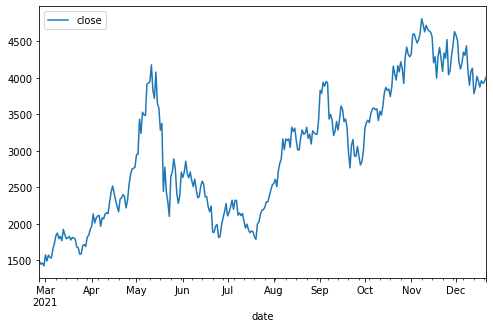

In [177]:
pair = "ETH/USD"
cryptoData = fetch_daily_cryptoData(symbol=pair)
cryptoData.plot(x='date',y='close')
cryptoData.head(10)

# Get reddit submissions
Store the posts into list to filter the data further.
Ref: https://praw.readthedocs.io/en/latest/index.html

In [178]:
import cred #myApp credentials 

reddit = praw.Reddit(username = cred.username,
                    password = cred.password,
                    client_id = cred.client_id,
                    client_secret = cred.client_secret,
                    user_agent = cred.user_agent)

subreddit = reddit.subreddit("ethtrader+") #subreddit to analyze

list_subms = []

for submission in subreddit.search('all', limit=None):
  list_subms.append(submission)

print(len(list_subms))

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



250


# Create dataframe with values of interest.
In this step dataframe is created, the data has different attributes, we are interseted in date / text / title attributes. Here data is also filtered, and posts related to news and analysis are fetched.

In [179]:
submissionList = []
submissionData = pd.DataFrame(columns=['created', 'author', 'title', 'text', 'flair', 'num_comments', 'upvote_ratio']) # empty df

for submission in list_subms:
  if (submission.link_flair_text == 'News') | (submission.link_flair_text == None) | (submission.link_flair_text == "Technicals") | (submission.link_flair_text == "Trading"):
    submissionList.append({'created':submission.created_utc,
                      'author':submission.author,
                      'title':submission.title,
                      'text':submission.selftext,
                      'flair':submission.link_flair_text,
                      'num_comments':submission.num_comments,
                      'upvote_ratio':submission.upvote_ratio})


submissionData = submissionData.append(submissionList, ignore_index=True) # store data into df
submissionData['created'] = pd.to_datetime(submissionData['created'], unit='s') # convert unix time into readable time
submissionData

,created,author,title,text,flair,num_comments,upvote_ratio
0,2021-12-01 02:17:42,naji102,ETH/BTC ratio is at .08241 is at highest level...,ETH has already broken out of its triangle if ...,Technicals,122,0.94000000
1,2021-11-21 01:41:05,greenpepperhypernova,"""I Need My Money"" Bank Calls The Police On A 6...",,News,121,0.89000000
2,2021-12-07 17:28:44,Hastyrunner245,Mukesh Ambani Talking About How DeFi Can Help ...,,Technicals,41,0.92000000
3,2021-11-27 01:08:40,InevitableComplex895,Even With All The FUD Today...Whats Important ...,"Even with all the FUD circulating today, whats...",Technicals,68,0.97000000
4,2021-12-13 00:45:20,stauffed5188,A ton of random scam airdrops showing up in my...,,Technicals,53,0.96000000
...,...,...,...,...,...,...,...
85,2021-09-07 22:27:17,Delam2,A reminder to all to keep things in perspectiv...,,Technicals,50,0.94000000
86,2021-11-28 15:50:50,ethereum88,"Know All About Gemini, The Winklevoss Cryptocu...",,Technicals,4,0.71000000
87,2021-10-30 02:32:25,dansparks69,Just bought $2 of $JASMY..any and all advice i...,Don't know if I should hold on to it and if I ...,Technicals,22,0.59000000
88,2021-11-24 18:16:39,Lggg1991,"Ethereum Metaverse Tokens Keep Climbing: MANA,...",,News,5,1.00000000


# Filtering the data.
Here the data is checked for NaN values. Those values are inserted by replacing the empty text attribute for each raw, then the data with NaN value is dropped.

The data is sorted by time and indexes are reseted.

In [180]:
submissionData = submissionData[(submissionData.upvote_ratio > 0.70) & (submissionData.author != "AutoModerator")].sort_values(by='created').replace(to_replace="", value=np.nan, inplace=False).dropna().reset_index(drop=True)
submissionData

,created,author,title,text,flair,num_comments,upvote_ratio
0,2021-10-20 10:04:55,christianjpberg,If you guys would stop selling your DONUT we a...,"Memecoins like Doge, Shib are Mooning and valu...",Technicals,29,0.75000000
1,2021-10-21 16:30:31,OneEssay3029,Question for all you,"Hello guys, I’m a beginner. I want to invest 2...",Technicals,37,0.86000000
2,2021-10-27 05:15:53,naji102,Some whale opened a $33 Million long on ETH lo...,"$33,575,668 $ETH LONGED @$4295.0 [27/10/21 05:...",Technicals,93,0.96000000
3,2021-11-04 23:24:46,yeyezhang,Opinion: Ether is the infrastructure of the me...,"Ether is the metaverse infrastructure, and ETH...",Technicals,17,0.95000000
4,2021-11-09 05:46:38,prince_bubba,To all the dummies waiting for a dip.,STFU and stop asking about these $200 price sw...,Technicals,123,0.83000000
5,2021-11-15 19:26:57,Mattelambo,"Advice- when you make the huge profits, don’t ...",\nI wanted to spread this advice that when you...,Technicals,40,0.89000000
6,2021-11-17 18:41:24,vis1onary,Are you guys selling all your eth at 10k,\n\n[View Poll](https://www.reddit.com/poll/qw...,Technicals,10,1.00000000
7,2021-11-19 17:02:53,salty-bois,Y'all Want Some Hopium? Take a Look at This:,This is 2017-2018: \n\n\nhttps://preview.redd...,Technicals,64,0.96000000
8,2021-11-21 19:02:51,pnapplxpress,Stake some or stake it all,Held ETH for a while now and relatively happy ...,Technicals,12,0.80000000
9,2021-11-22 06:45:38,Fluid_Department_120,Ethereum Layer 2 TVL has more than doubled ove...,The total value locked (TVL) on Ethereum layer...,Technicals,14,1.00000000


# Visualizing the frequency of words in posts.

This visualization is done using a word cloud module. Here I wanted to see how the meaning of submissions fits with the concept.

Ref: https://amueller.github.io/word_cloud/

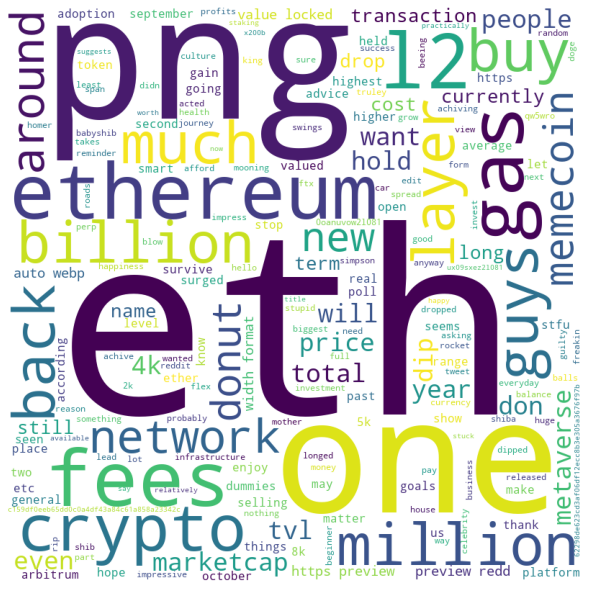

In [181]:
from wordcloud import WordCloud, STOPWORDS

words = ''
stopwords = set(STOPWORDS)

for val in submissionData.text:
    tokens = val.split()#split text into tokens 
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(words)
 
# plot the wordcloud                     
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

We can see that most of the words are relateble to the topic, so we can move to the next step, where we will do sentimental analysis.

# Sentiment Analysis using Flair.
Here the text of each submission in the dataframe is analyzed. The result of analysis is a probability `p`, which describes how positive or negative is the text. We want to see the probability values and compare them to the ETH price we aquired before.

Ref: https://www.analyticsvidhya.com/blog/2019/02/flair-nlp-library-python/

In [182]:
from flair.models import TextClassifier
from flair.data import Sentence

sia = TextClassifier.load('en-sentiment') # localization

def flair_prediction(x):
    sentence = Sentence(x)
    sia.predict(sentence)
    score = sentence.labels[0]
    return score.score #probabilit score is returned

submissionData['analysis'] = submissionData['text'].apply(flair_prediction) # apply sentiment analysis function on each data entry

submissionData.head()

2021-12-21 06:09:25,686 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


,created,author,title,text,flair,num_comments,upvote_ratio,analysis
0,2021-10-20 10:04:55,christianjpberg,If you guys would stop selling your DONUT we a...,"Memecoins like Doge, Shib are Mooning and valu...",Technicals,29,0.75000000,0.68629646
1,2021-10-21 16:30:31,OneEssay3029,Question for all you,"Hello guys, I’m a beginner. I want to invest 2...",Technicals,37,0.86000000,0.76858389
2,2021-10-27 05:15:53,naji102,Some whale opened a $33 Million long on ETH lo...,"$33,575,668 $ETH LONGED @$4295.0 [27/10/21 05:...",Technicals,93,0.96000000,0.99353653
3,2021-11-04 23:24:46,yeyezhang,Opinion: Ether is the infrastructure of the me...,"Ether is the metaverse infrastructure, and ETH...",Technicals,17,0.95000000,0.99335611
4,2021-11-09 05:46:38,prince_bubba,To all the dummies waiting for a dip.,STFU and stop asking about these $200 price sw...,Technicals,123,0.83000000,0.99978095


We can now see that there is an attribute for each frame entry, called analysis, but the values are far from good. Text in the post is sometimes too big, and this influences the performance of analyzer, so we cannot consider the result as a good one. But still Let's plot the graph and see what we got.

In [183]:
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime

# Visualization of price and sentiment analysis.

Here we are trying to see if there is a correlation between coin price and sentiment analysis.

In [184]:
crypto = cryptoData[(cryptoData.date >= '2021-10-20') & (cryptoData.date <= '2021-12-3')] # create a copy of crypto data with particular range
# plot candlestick chart
fig = go.Figure(data=[go.Candlestick(x=crypto['date'],
                open=crypto['open'],
                high=crypto['high'],
                low=crypto['low'],
                close=crypto['close'])])
fig.show()
# plot line chart for probability values 
fig = px.line(submissionData, x="created", y="analysis")
fig.show()
# plot line chart for coin price
fig = px.line(cryptoData[(cryptoData.date >= '2021-10-20') & (cryptoData.date <= '2021-12-3')], x='date', y='close', title='prob')
fig.show()



Now we can see that there are some similarities in the form of the trend line on both charts, but as I mentioned before, we cannot rely on the sentiment analysis, because of its poor performance in this project. We could get better results if we found a better source of information, like Twitter's paid API, but I, personally, think that it is more than enough for the project:)

# Fetching data from Google Trends.

The next step is to fetch the frequency of serching the word 'ETHERIUM' on google. I will use google trend api wrapper for python here, after we get the data, we will also look at the correlation by visualizing the charts again.

Ref: https://github.com/GeneralMills/pytrends

In [185]:
!pip install pytrends

Connecting to Google Trends.

In [187]:
from pytrends.request import TrendReq

pytrends = TrendReq(hl='en-US', tz=360) 
keyword = ["ethereum"] # list of keywords to get data 
pytrends.build_payload(keyword, cat=0, timeframe='today 12-m')

Now we can visualize both data sets.

In [188]:
trend = pytrends.interest_over_time() 
trend = trend.reset_index() 

fig = px.line(trend[(trend.date >= '2021-02-24')], x='date', y='ethereum', title='Keyword Web Search Interest Over Time')
fig.show() 

fig = px.line(cryptoData, x='date', y='close', title='ETH/USD')
fig.show()

# Smoothing the Trend Data.

As we can see there might be some correlation between the price of ETH and the frequency of ETH serach on the web. To get rid of unnecessary price ticks, lets smoothen the price data.

In [189]:
from statsmodels.nonparametric.smoothers_lowess import lowess

ethSmooth = pd.DataFrame(
    lowess(cryptoData.close, np.arange(len(cryptoData.close)), frac=0.05)[:,1],
    index=cryptoData.date, columns=['close']
)

ethSmooth.head()

fig = px.line(trend[(trend.date >= '2021-02-24')], x='date', y='ethereum', title='Keyword Web Search Interest Over Time')
fig.show() 

fig = px.line(ethSmooth, x=ethSmooth.index, y='close', title='ETH/USD')
fig.show()

## We got some good correlation in the May.


# Predicting the price.

In this part I will try to build and evaluate a price prediciton module for EHT.

---
First we need to decompose the data. This is done to select the best modeling technique.

---



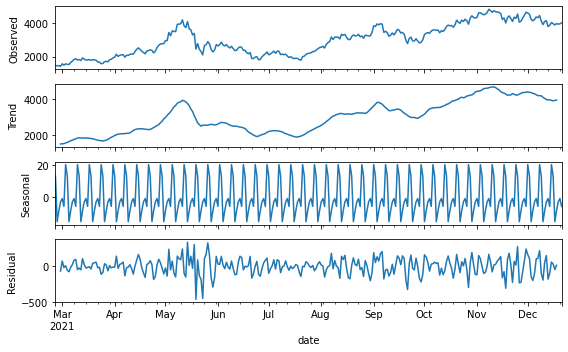

In [190]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

cryptoData = pd.read_csv('Coinbase_ETHUSD_dailyData.csv', parse_dates=['date']).set_index('date')
# decomposition 
decompositionResult = seasonal_decompose(cryptoData.close)
# plot
plt.rcParams.update({'figure.figsize': (8,5)})
decompositionResult.plot()
plt.show()

We can see that the data has an uptrend and monthly seasonality. So we can think of which model to apply on the data set.

# Checking Stationarity.
The ADF approach is a statistical significance test that compares the p-value with the critical values and does hypothesis testing. Using this test, we can determine whether the processed data is stationary or not with different levels of confidence.

Ref: https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one/

In [191]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=7).mean() 
    rolstd = pd.Series(timeseries).rolling(window=7).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

 > Is the raw data stationary ?
Test statistic = -1.017
P-value = 0.747
Critical values :
	1%: -3.4524859843440754 - The data is not stationary with 99% confidence
	5%: -2.871288184343229 - The data is not stationary with 95% confidence
	10%: -2.571964047565425 - The data is not stationary with 90% confidence


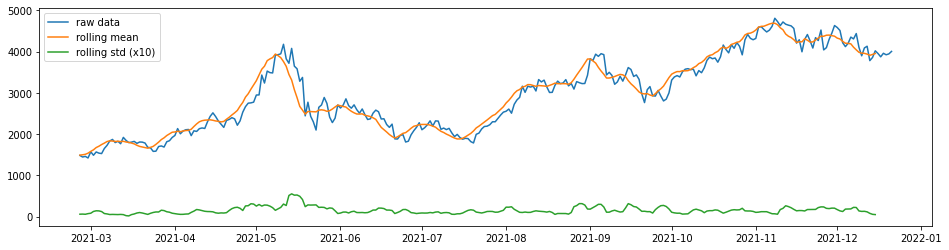

In [192]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(cryptoData.close,'raw data')

ADF_test(cryptoData.close,'raw data')

## The data has to be stationarized + differenced.

 > Is the de-trended data stationary ?
Test statistic = -8.112
P-value = 0.000
Critical values :
	1%: -3.4534232986669546 - The data is  stationary with 99% confidence
	5%: -2.8716994185534745 - The data is  stationary with 95% confidence
	10%: -2.5721833625116144 - The data is  stationary with 90% confidence


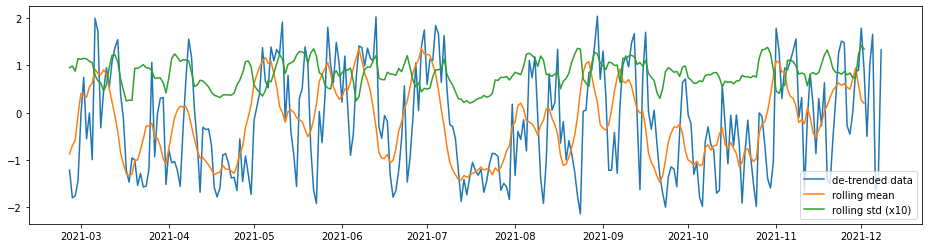

In [193]:
crypto_detrend=(cryptoData.close - cryptoData.close.rolling(window=7).mean())/cryptoData.close.rolling(window=7).std()
crypto_diff=crypto_detrend - crypto_detrend.shift(7)

crypto_sta = crypto_detrend - crypto_diff

test_stationarity(crypto_sta,'de-trended data')
ADF_test(crypto_sta,'de-trended data')

We now can apply our model on the data set.

# Create training and testing datasets.

In [194]:
cryptoData = cryptoData.sort_index()

train = cryptoData[:'2021-10-20'] # dataset to train
val = cryptoData['2021-10-20':] # last X months for test  
predict_date = len(cryptoData) - len(cryptoData[:'2021-10-20']) # the number of data points for the test set

# Training the model, and forecasting results.

I will be using the Holt-Winters' Seasonal Method to train the model and predict ETH price from October to December. 

Ref: https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-two/

In [195]:
from statsmodels.tsa.api import ExponentialSmoothing

def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_date):
    
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add').fit(use_boxcox=True)
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        mse1 = ((fcast1 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))
        
        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
        fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
        mse2 = ((fcast2 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))
        
        fit1.fittedvalues.plot(style='--', color='red')
        fcast1.plot(style='--', marker='o', color='red', legend=True)
        fit2.fittedvalues.plot(style='--', color='green')
        fcast2.plot(style='--', marker='o', color='green', legend=True)
    
    elif seasonal_type == 'multiplicative':  
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul').fit(use_boxcox=True)
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        mse3 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))
        
        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        mse4 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))
        
        fit3.fittedvalues.plot(style='--', color='red')
        fcast3.plot(style='--', marker='o', color='red', legend=True)
        fit4.fittedvalues.plot(style='--', color='green')
        fcast4.plot(style='--', marker='o', color='green', legend=True)
        
    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



The Root Mean Squared Error of additive trend, additive seasonal of period season_length=30 and a Box-Cox transformation 959.93


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



The Root Mean Squared Error of additive damped trend, additive seasonal of period season_length=30 and a Box-Cox transformation 349.11


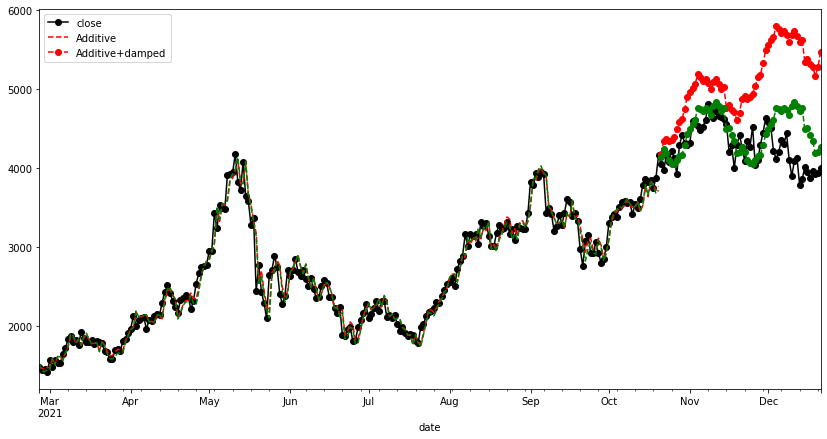

In [196]:
model = holt_win_sea(cryptoData.close, train.close, val.close,'additive', 30, predict_date)